In [ ]:
from google.colab import drive
drive.mount('content')

Mounted at content


In [ ]:
!pip install segmentation_models_pytorch==0.2.1

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
import os
import torch
import torchvision
import numpy as np
import cv2
from sklearn.cluster import DBSCAN
import segmentation_models_pytorch as smp

In [ ]:
FEATURES_SIZE = 256
PCA_FEATURE_SIZE = 30
SIZE = 256
IMAGE_SIZE = (SIZE, SIZE)
NUM_CHANNELS = 3
NUM_OF_PICTURES = 8
indices = [i for i in range(NUM_OF_PICTURES)]
metric = torch.nn.CosineSimilarity(dim=1, eps=1e-08)

In [ ]:
model = torch.load('content/MyDrive/models/pixel_wise_encoder_v14.pt', map_location=torch.device('cpu'))
model.eval()

In [ ]:
batch = torch.zeros((NUM_OF_PICTURES, *IMAGE_SIZE, NUM_CHANNELS))
for idx in indices:
  im = cv2.imread(f'content/MyDrive/photos/{idx}.jpg')
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = (cv2.resize(im, IMAGE_SIZE) / 255).astype('float32')
  batch[idx, :, :, :] = torch.tensor(im)
batch = batch.permute(0, 3, 1, 2)

In [ ]:
pred = model(batch).permute(0, 2, 3, 1).detach()

In [ ]:
pred.shape

torch.Size([8, 256, 256, 256])

# **ФУНКЦИИ**

In [ ]:
def labeling_DBSCAN(pred, features_size=256, eps=0.0005, min_samples=10):
  labels = torch.zeros((NUM_OF_PICTURES, *IMAGE_SIZE), dtype=int)
  for i in indices:
    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine', ).fit(pred[i].reshape(-1, features_size))
    label = clustering.labels_
    label = label.reshape(*IMAGE_SIZE)
    labels[i] = torch.tensor(label)
  return labels

In [ ]:
def mean_vectors_marking(pred, threshold=0.1, features_size=256, eps=0.0005, min_samples=10):
  local_labels = labeling_DBSCAN(pred, features_size, eps, min_samples)

  #local_labels = labels.clone()

  unique = torch.unique(local_labels[0])
  mean_vectors = torch.zeros((unique.shape[0], features_size), dtype=float)
  mean_vectors_to_unique = {}    # {mean_vectors_idx : unique_idx}
  for i, num in enumerate(unique):
    mask = local_labels[0] == num
    mean_vector = torch.mean(pred[0][mask], dim=0, dtype=float)
    mean_vectors[i] = mean_vector
    mean_vectors_to_unique[i] = num.item()
  for i in range(1, len(indices)):
    local_labels[i] += unique.shape[0] + torch.unique(local_labels[i]).shape[0]
    temp = torch.unique(local_labels[i])
    for num in temp:
      mask = local_labels[i] == num
      mean_vector = torch.mean(pred[i][mask], dim=0, dtype=float)
      m = metric(mean_vector, mean_vectors)
      comparsion = m > 1-threshold
      nonzero = torch.nonzero(comparsion)[:, 0]
      if nonzero.shape[0] == 0:
        new_num = (unique[-1]+1).item()
        unique = torch.cat((unique, torch.tensor([new_num])))
        mean_vectors_to_unique[mean_vectors.shape[0]] = new_num
        mean_vectors = torch.cat((mean_vectors, mean_vector[None]), dim=0)
        local_labels[i][mask] = new_num
      else:
        idx = torch.argmax(m).item()
        old_num = mean_vectors_to_unique[idx]
        local_labels[i][mask] = old_num
  return local_labels

In [ ]:
def show_result(labels):
  labels_to_show = labels[0]
  pic_to_show = batch[0]
  for i in range(1, len(indices)):
    labels_to_show = torch.cat((labels_to_show, labels[i]), dim=0)
    pic_to_show = torch.cat((pic_to_show, batch[i]), dim=1)

  result = np.zeros((*labels_to_show.shape, NUM_CHANNELS), dtype=np.int32)
  for num in np.unique(labels_to_show):
      mask = labels_to_show==num
      for i in range(3):
          np.putmask(result[:, :, i], mask, np.random.randint(0, 200))

  figsize = (20, 20)
  f, ax = plt.subplots(1, 2, figsize=figsize)

  ax[0].imshow(result)
  ax[1].imshow(pic_to_show.permute(1, 2, 0))
  plt.show()
  return result

In [ ]:
local_labels = mean_vectors_marking(pred, features_size=FEATURES_SIZE)

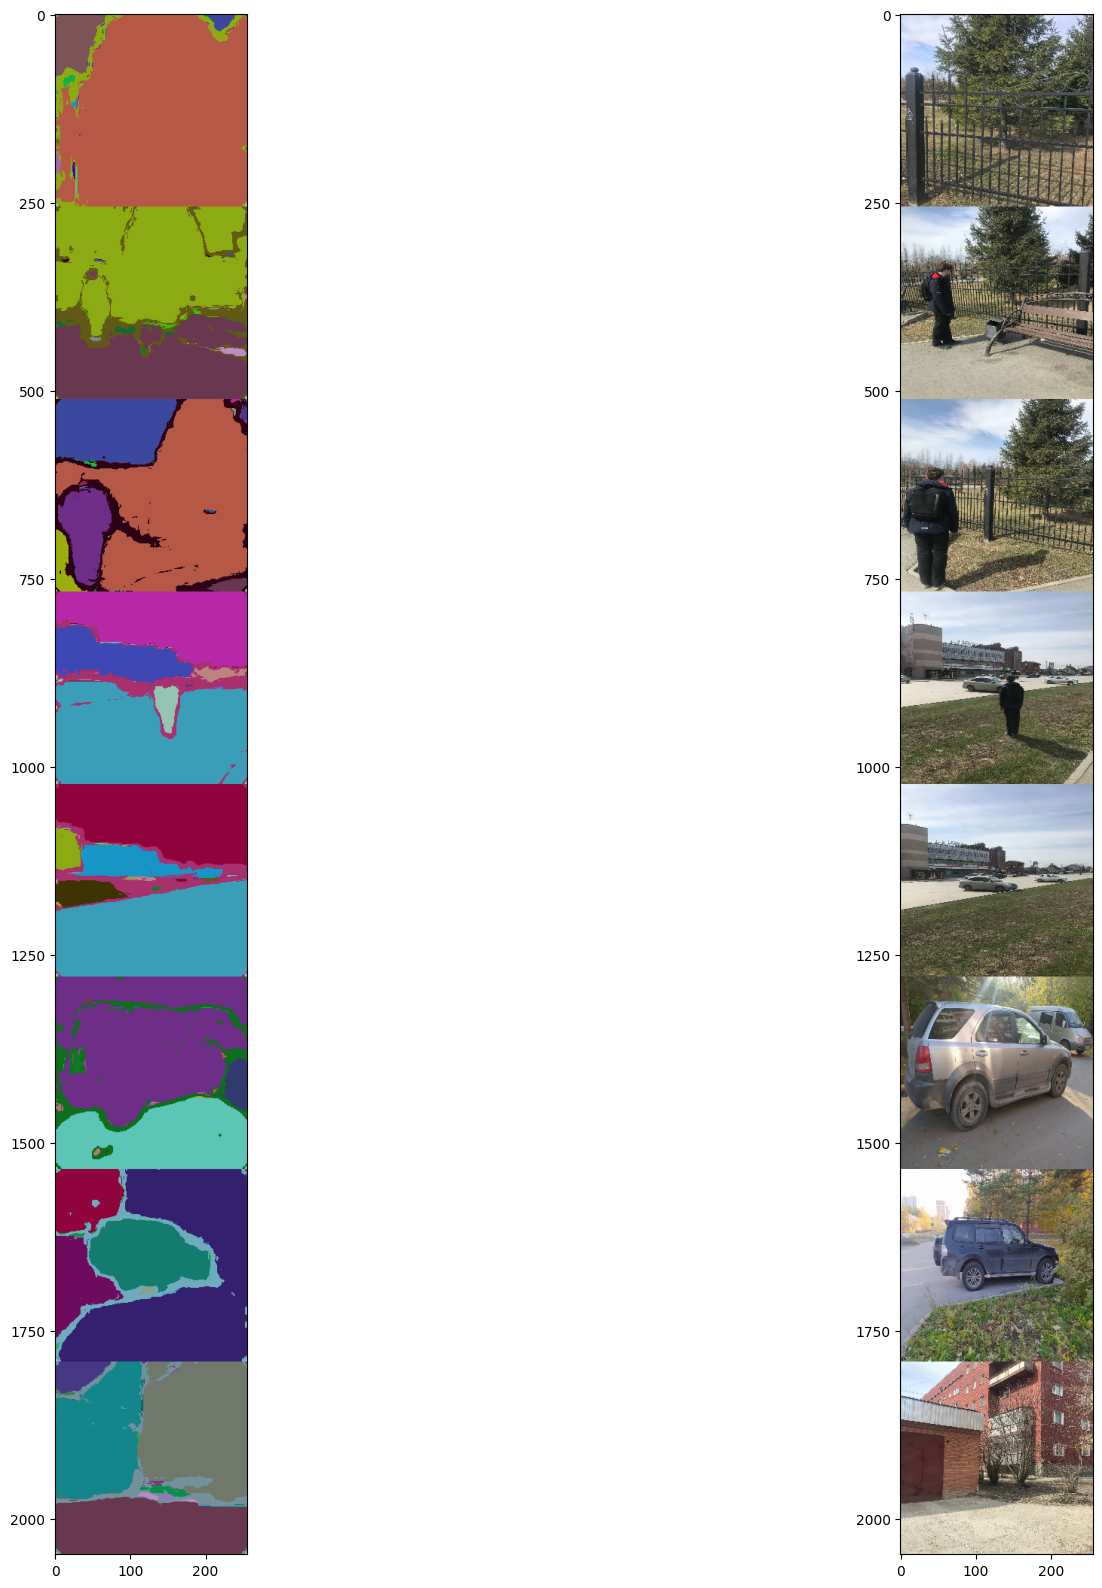

In [ ]:
result1 = show_result(local_labels)

# **PCA**

In [ ]:
import typing as tp
from torchvision.transforms import ToTensor
from sklearn.decomposition import PCA


class BaseVectorization:
    def __init__(
            self,
            model: torch.nn.Module,
            image_size: tp.Tuple[int, int],
            device: str = 'cuda',
    ):
        self.model = model
        self.image_size = image_size

        self.device = device

        self.imgs = None
        self.outs = None

    def _predict(self, imgs: torch.Tensor) -> np.ndarray:
        with torch.no_grad():
            outs = self.model(imgs.to(self.device)).detach().cpu().numpy()
        outs = np.moveaxis(outs, 1, -1)
        return outs

    def _vectorization(self, imgs: np.ndarray, outs: np.ndarray) -> np.ndarray:
        raise NotImplementedError

    def vectorization(self, imgs: tp.Union[tp.List[str], torch.Tensor], always_update: bool = True) -> np.ndarray:
        if always_update or (self.imgs is None) or (self.outs is None):
            if isinstance(imgs, list):
                self.imgs = self._read_images(imgs)
            self.outs = self._predict(self.imgs)
            self.imgs = self.imgs.detach().cpu().numpy()
            self.imgs = np.moveaxis(self.imgs, 1, -1)
        vect = self._vectorization(self.imgs, self.outs)
        return vect

    def _read_images(self, images_paths: tp.List[str]) -> torch.Tensor:
        images = []
        for image_path in images_paths:
            im = cv2.imread(image_path)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            im = (cv2.resize(im, self.image_size) / 255).astype('float32')
            im = ToTensor()(im)
            images.append(im.unsqueeze(0))
        images = torch.cat(images, dim=0)
        return images

class PCAVectorization(BaseVectorization):
    def __init__(
            self,
            model,
            image_size,
            num_channels=3,
            pca_every=10,
            device='cuda',
    ):
        super(PCAVectorization, self).__init__(
            model=model,
            image_size=image_size,
            device=device,
        )
        self.num_channels = num_channels
        self.pca = PCA(n_components=num_channels)
        self.pca_every = pca_every

    def _normalize(self, vectorization_out: np.ndarray) -> np.ndarray:
        for channel in range(self.num_channels):
            cres = vectorization_out[:, :, :, channel: channel + 1]
            std = np.std(cres)
            mean = np.mean(cres)
            left = mean - 3 * std
            right = mean + 3 * std
            cres = (cres - left) / (right - left)
            cres[cres < 0] = 0
            cres[cres > 1] = 1
            vectorization_out[:, :, :, channel: channel + 1] = cres
        return vectorization_out

    def _vectorization(self, imgs: np.ndarray, outs: np.ndarray) -> np.ndarray:
        flatten = outs.reshape(-1, outs.shape[-1])
        self.pca.fit(flatten[::self.pca_every])
        res_flatten = self.pca.transform(flatten)
        vectorization_out = res_flatten.reshape((*outs.shape[:-1], self.num_channels))
        vectorization_out = self._normalize(vectorization_out)
        return vectorization_out

In [ ]:
pca = PCAVectorization(model=model, image_size=IMAGE_SIZE, num_channels=PCA_FEATURE_SIZE, device='cpu')

In [ ]:
reduced_pred = torch.tensor(pca.vectorization([f'content/MyDrive/photos/{i}.jpg' for i in range(NUM_OF_PICTURES)]))

In [ ]:
reduced_pred.shape

torch.Size([8, 256, 256, 30])

In [ ]:
local_pca_labels = mean_vectors_marking(reduced_pred, features_size=PCA_FEATURE_SIZE, eps=0.0005, min_samples=10)

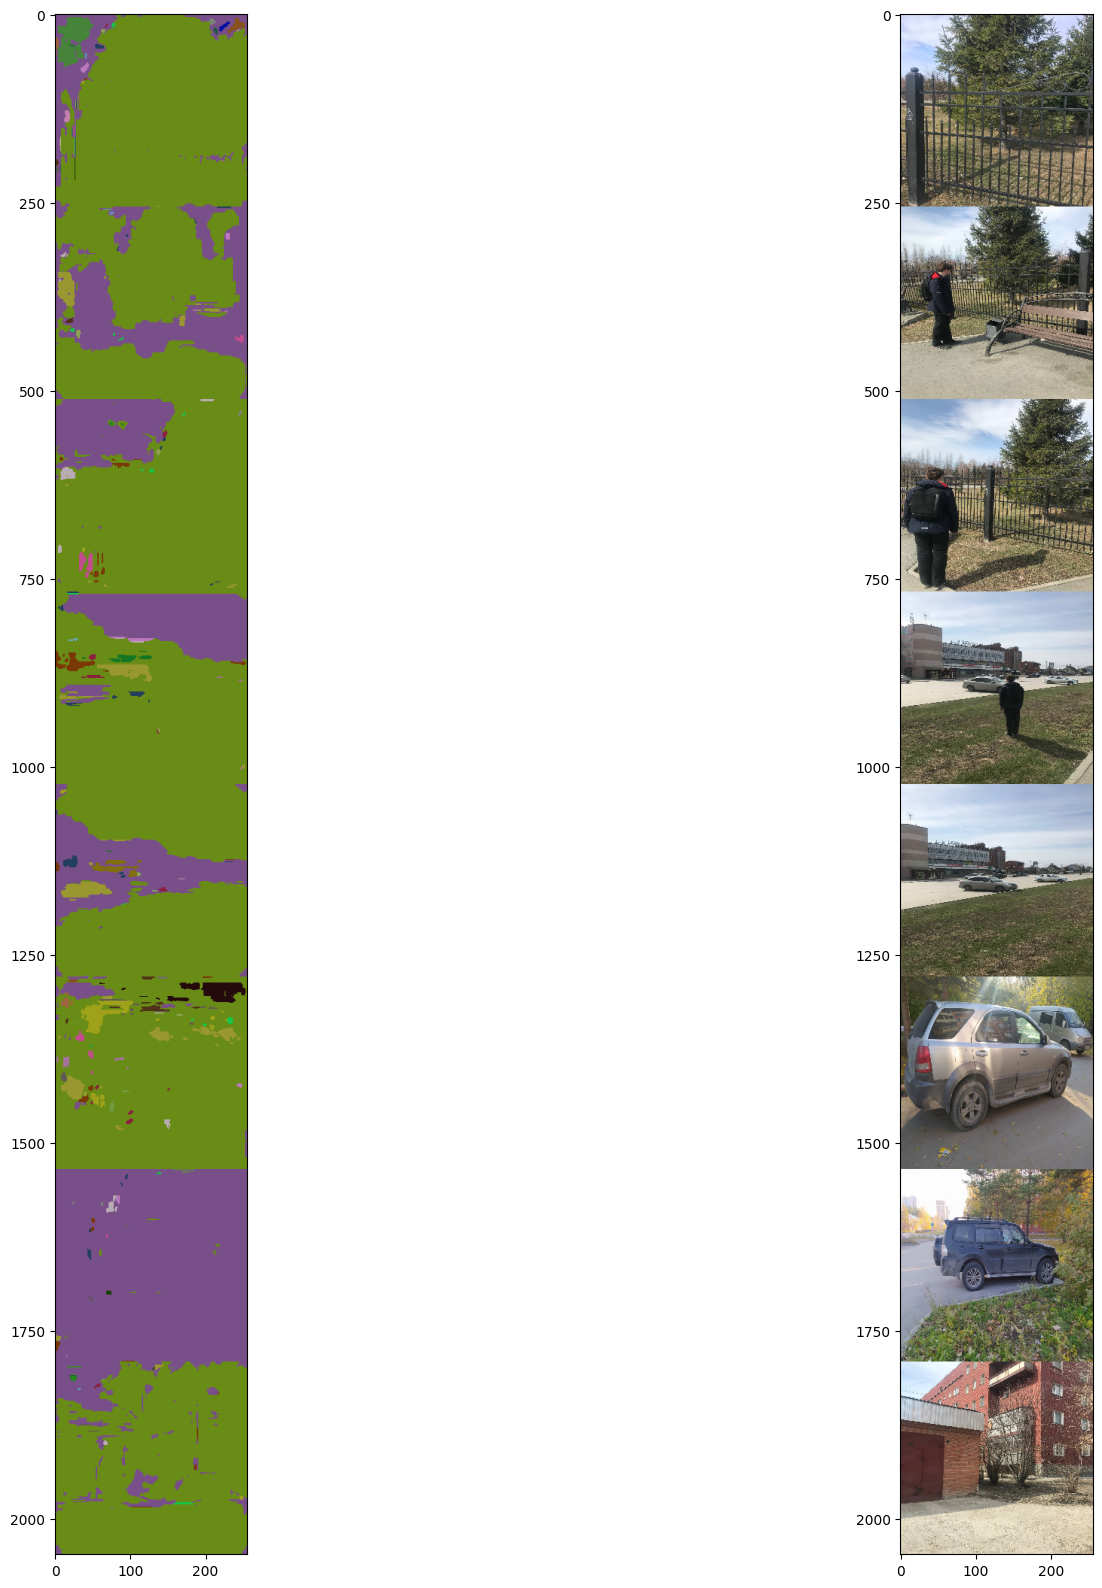

array([[[121,  79, 137],
        [121,  79, 137],
        [121,  79, 137],
        ...,
        [121,  79, 137],
        [121,  79, 137],
        [121,  79, 137]],

       [[121,  79, 137],
        [121,  79, 137],
        [121,  79, 137],
        ...,
        [121,  79, 137],
        [121,  79, 137],
        [121,  79, 137]],

       [[121,  79, 137],
        [121,  79, 137],
        [121,  79, 137],
        ...,
        [121,  79, 137],
        [121,  79, 137],
        [121,  79, 137]],

       ...,

       [[121,  79, 137],
        [121,  79, 137],
        [121,  79, 137],
        ...,
        [121,  79, 137],
        [121,  79, 137],
        [121,  79, 137]],

       [[121,  79, 137],
        [121,  79, 137],
        [121,  79, 137],
        ...,
        [121,  79, 137],
        [121,  79, 137],
        [121,  79, 137]],

       [[121,  79, 137],
        [121,  79, 137],
        [121,  79, 137],
        ...,
        [121,  79, 137],
        [121,  79, 137],
        [121,  79, 137]]

In [ ]:
show_result(local_pca_labels)

# **СРЕДНИЕ ВЕКТОРА В DBSCAN**

In [ ]:
#label_copy = labeling_DBSCAN(pred)

In [ ]:
pred.shape

torch.Size([1, 256, 256, 256])

In [ ]:
labels = local_labels.clone()

In [ ]:
labels.shape

torch.Size([8, 256, 256])

In [ ]:
count = 0
for label in labels:
  unique = torch.unique(label)
  count += len(set(unique))


mean_vectors = torch.zeros((count, FEATURES_SIZE), dtype=float)

counter = 0
for i, label in enumerate(labels):
  unique = torch.unique(label)
  for lab in unique:
    mask = label == lab
    mean_vector = torch.mean(pred[i][mask], dim=0, dtype=float)
    mean_vectors[counter] = mean_vector
    counter += 1


In [ ]:
mean_vectors.shape

torch.Size([162, 256])

In [ ]:
clustering = DBSCAN(eps=0.001, min_samples=1, metric='cosine', ).fit(mean_vectors)
new_label = clustering.labels_

In [ ]:
counter = 0
for i, label in enumerate(labels):
  unique = torch.unique(label)
  for lab in unique:
    mask = label == lab
    labels[i][mask] = new_label[counter] + len(new_label)
    counter += 1

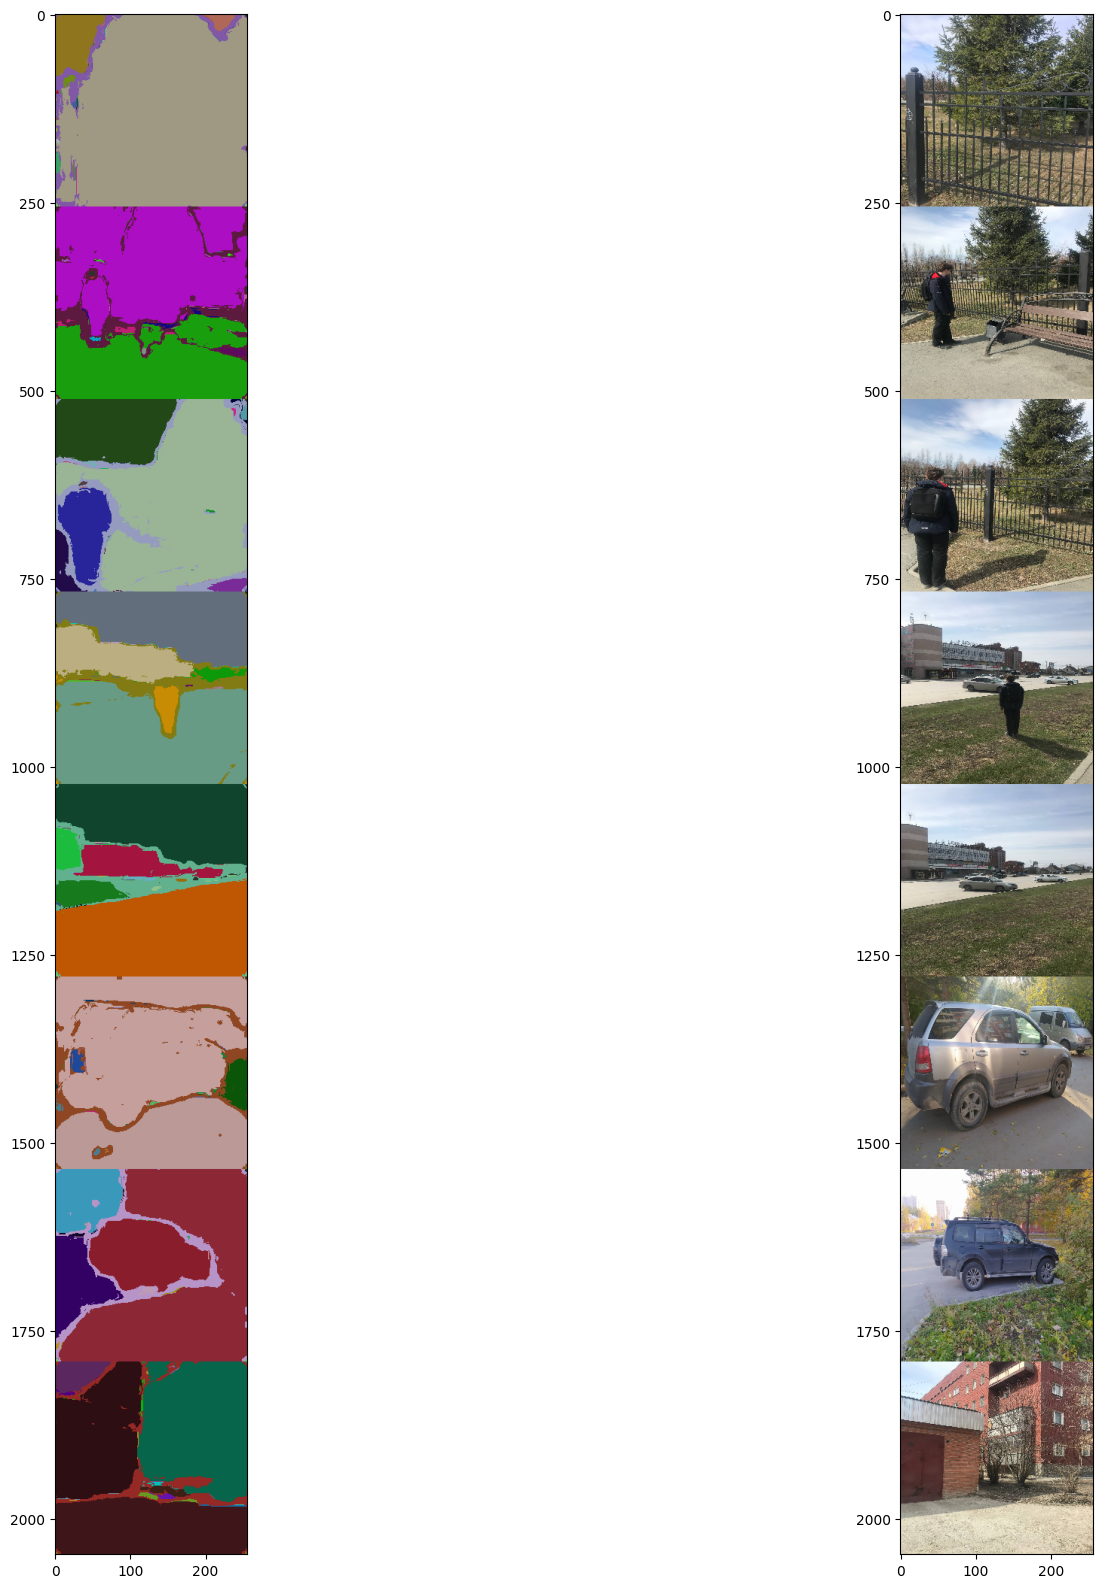

In [ ]:
result2 = show_result(labels)

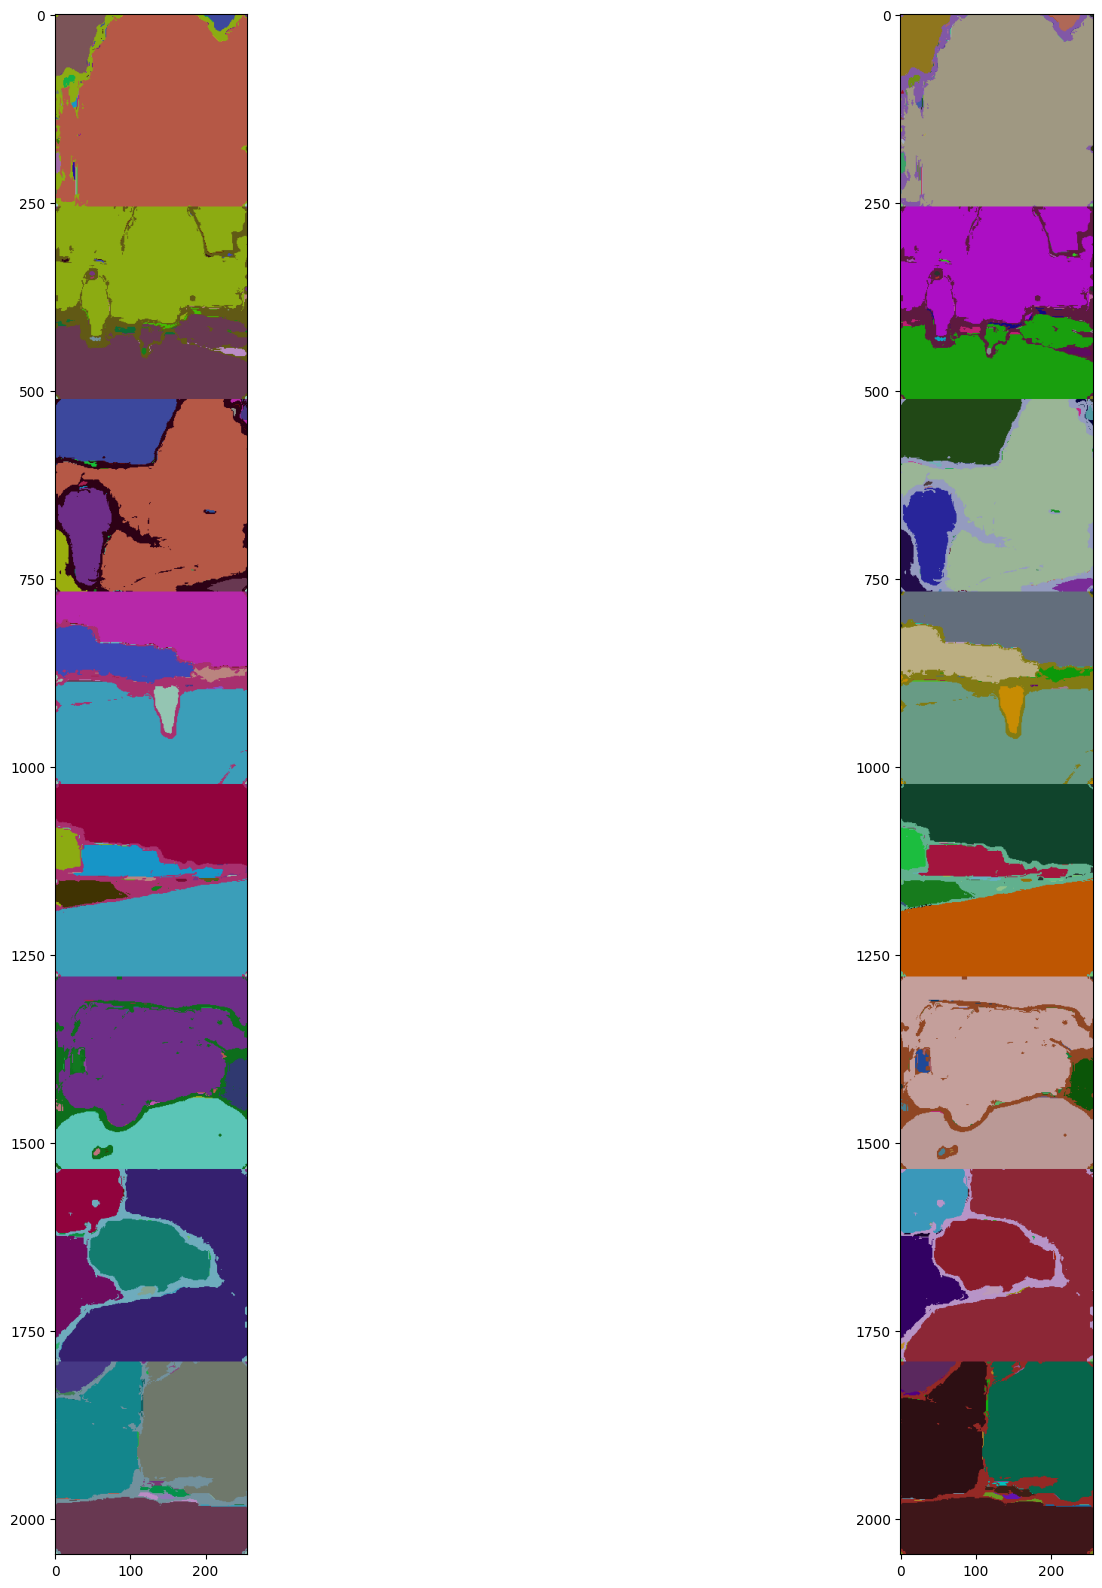

In [ ]:
figsize = (20, 20)
f, ax = plt.subplots(1, 2, figsize=figsize)
ax[0].imshow(result1)
ax[1].imshow(result2)
plt.show()

51


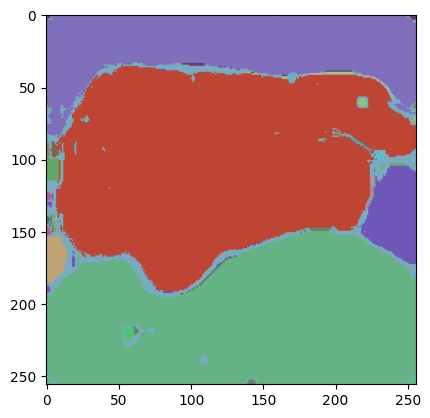

In [ ]:
im = cv2.imread(f'content/MyDrive/photos/{10}.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = (cv2.resize(im, IMAGE_SIZE) / 255).astype('float32')
im = torch.tensor(im)
im = im.permute(2, 0, 1)
pred = model(im[None]).detach()

clustering = DBSCAN(eps=0.001, min_samples=10, metric='cosine', ).fit(pred.reshape(FEATURES_SIZE, -1).permute(1, 0))

labels = clustering.labels_
unique = set(labels)
print(len(unique))
labels = torch.tensor(labels).reshape(*IMAGE_SIZE)
result = np.zeros((*IMAGE_SIZE, NUM_CHANNELS), dtype='uint8')
for num in unique:
  mask = labels==num
  for i in range(3):
    np.putmask(result[:, :, i], mask, np.random.randint(50, 200))

plt.imshow(result)

In [ ]:
!pip list

In [ ]:
pred.shape

torch.Size([1, 256, 256, 256])

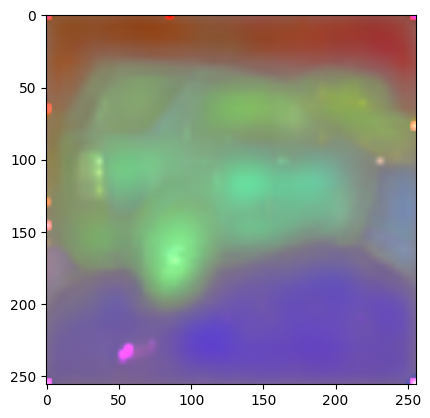

In [ ]:
pca = PCAVectorization(model=model, image_size=IMAGE_SIZE, num_channels=3, device='cpu')
reduced_pred = torch.tensor(pca.vectorization([f'content/MyDrive/photos/{5}.jpg']))
plt.imshow(reduced_pred[0])